# End-to-End Demand Forecasting System

## Objective
The goal of this project is to build an end-to-end demand forecasting system using historical retail sales data.  
The forecasted demand can help businesses plan inventory, reduce stock-outs, and optimize revenue.

## Dataset
- Retail store-item daily sales data
- Multiple stores and multiple products
- Time period spans several years


## 1. Business Understanding

Demand forecasting is critical in retail and supply chain management.  
Accurate forecasts help organizations:
- Avoid overstocking and inventory holding costs
- Prevent stock-outs and lost sales
- Plan procurement and logistics efficiently

In this project, we aim to forecast future demand using time-series models and evaluate their performance.


In [2]:
import pandas as pd
import numpy as np 

## 2. Data Loading

The dataset is loaded using Pandas.  
We begin by inspecting the structure, columns, and size of the data to understand its composition.


In [3]:
df = pd.read_csv("train.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [5]:
df.head(5)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [6]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [7]:
df.shape

(913000, 4)

In [8]:
# Checks the Unique store & Item
print(df['store'].nunique())
print(df['item'].nunique())

10
50


In [9]:
# How many years of data we have 
print(df['date'].min())
print(df['date'].max())
# --> 5Years of data (Enough for seasonality)

2013-01-01
2017-12-31


### I have daily sales data of store-item combination over 5 years, Before analysis I must ensure time is clean, ordered and continues

## 3. Data Cleaning and Preparation

This step ensures the dataset is suitable for time-series analysis:
- Convert date column to datetime format
- Sort data by store, item, and date
- Check for missing values and duplicate records
- Validate time continuity


In [10]:
df['date'] = pd.to_datetime(df['date'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [12]:
# Sort the data by time 
df = df.sort_values(['store','item','date'])

In [13]:
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [14]:
# Check Duplicates
df.duplicated(subset=['date', 'store', 'item']).sum()

np.int64(0)

In [15]:
# Checked the missing dates
sample_key = df[(df['store'] == 1) & (df['item'] == 1)]

full_dates = pd.date_range(
    start = sample_key['date'].min(),
    end = sample_key['date'].max(),
    freq = 'D'
)
missing_dates = full_dates.difference(sample_key['date'])
len(missing_dates)

0

## 4. Exploratory Data Analysis (EDA)

EDA helps understand demand behavior over time.
We analyze:
- Overall sales trends
- Seasonality patterns
- Differences across stores and products


In [16]:
daily_sales = df.groupby('date')['sales'].sum().reset_index()
daily_sales
# Total sales per Day

,date,sales
0,2013-01-01,13696
1,2013-01-02,13678
2,2013-01-03,14488
3,2013-01-04,15677
4,2013-01-05,16237
...,...,...
1821,2017-12-27,20378
1822,2017-12-28,21885
1823,2017-12-29,23535
1824,2017-12-30,24988


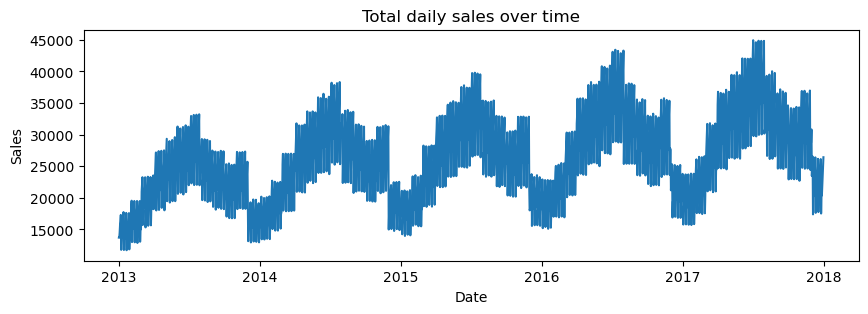

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,3))
plt.plot(daily_sales['date'], daily_sales['sales'])
plt.title('Total daily sales over time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

**Observation:**  
The sales data shows a clear upward trend along with strong seasonal patterns, indicating that demand is non-stationary and influenced by recurring factors.


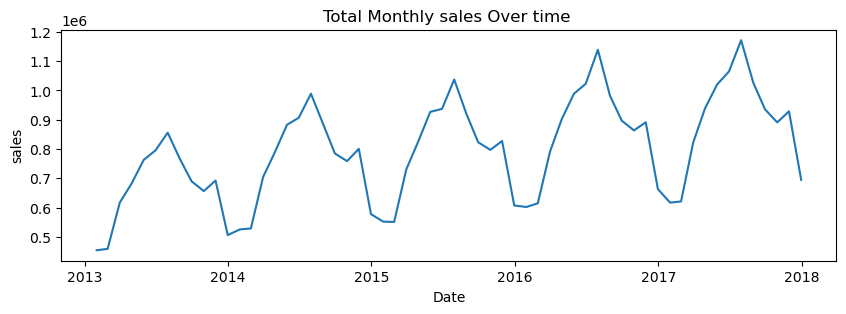

In [18]:
monthly_sales = (
    daily_sales.set_index('date').resample('ME').sum()
)

plt.figure(figsize=(10,3))
plt.plot(monthly_sales.index, monthly_sales['sales'])
plt.title('Total Monthly sales Over time ')
plt.xlabel('Date')
plt.ylabel('sales')
plt.show()

In [19]:
store_sales = df.groupby(['date','store'])['sales'].sum().reset_index()

In [20]:
store_sales

,date,store,sales
0,2013-01-01,1,1316
1,2013-01-01,2,1742
2,2013-01-01,3,1588
3,2013-01-01,4,1423
4,2013-01-01,5,1032
...,...,...,...
18255,2017-12-31,6,2009
18256,2017-12-31,7,1831
18257,2017-12-31,8,3205
18258,2017-12-31,9,2774


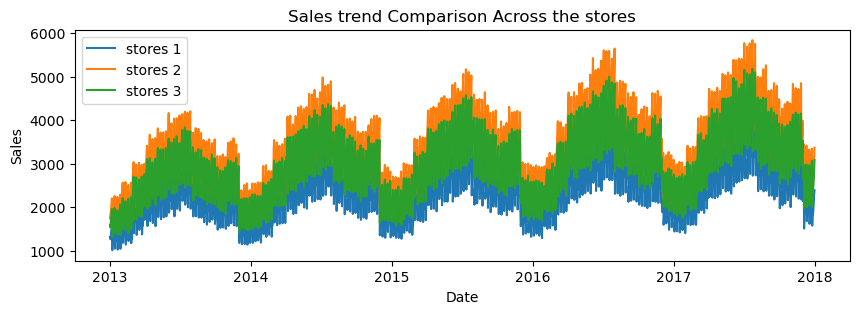

In [21]:
plt.figure(figsize= (10,3))

for s in [1,2,3]:
    temp = store_sales[store_sales['store'] == s]
    plt.plot(temp['date'], temp['sales'], label = f"stores {s}")

plt.legend()
plt.title("Sales trend Comparison Across the stores")
plt.xlabel('Date')
plt.ylabel("Sales")
plt.show()

### 
* Stores have different demand Patterns
* One global model may not fit all perfectly

## 5. Time Series Decomposition

Time series decomposition separates the data into:
- Trend
- Seasonality
- Residual (noise)

This helps confirm the presence of trend and seasonal components before applying forecasting models.


In [22]:
sample_series = df[(df['store'] == 1) & (df['item'] == 1)]

monthly_series = (
    sample_series.set_index('date')
    .resample('ME')
    .sum()
)

In [23]:
# monthly_series

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [25]:
decomposition = seasonal_decompose(
    monthly_series['sales'],
    model = 'additive'
)

<Figure size 1200x900 with 0 Axes>

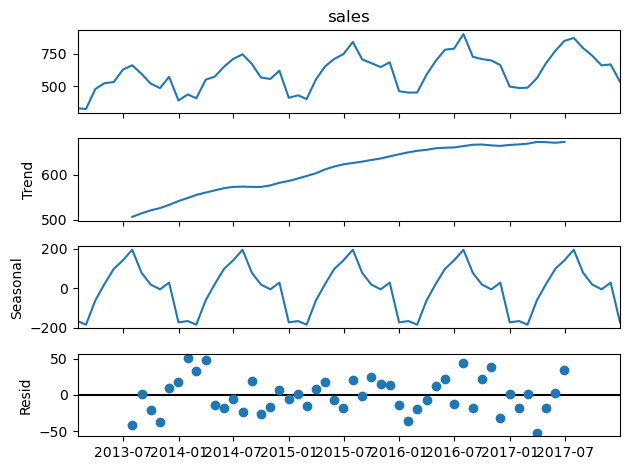

In [26]:
plt.figure(figsize = (12,9))
decomposition.plot()
plt.show()

## 6. Train-Test Split (Time-Based)

For time-series data, random splitting is inappropriate.  
The dataset is split based on time to simulate real-world forecasting, where future values are predicted using past data.


In [27]:
ts = monthly_sales['sales']

In [28]:
train = ts.iloc[:-6]
test = ts.iloc[-6:]

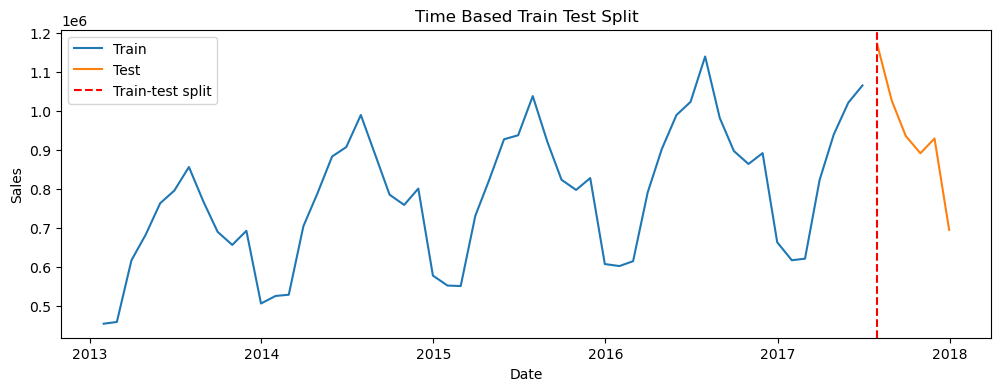

In [29]:
plt.figure(figsize = (12,4))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label= 'Test')
plt.axvline(test.index[0], color = 'red', linestyle= '--', label= 'Train-test split') # add the vertical line across the axes at specified X position
plt.legend()
plt.title("Time Based Train Test Split")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

## 7. Baseline Model

A simple moving average model is used as a baseline.  
This provides a benchmark to evaluate whether advanced models actually improve forecasting performance.


In [30]:
window = 3
baseline_forecast = train.rolling(window).mean().iloc[-1]

baseline_prediction = pd.Series(
    [baseline_forecast] * len(test),
    index = test.index
)

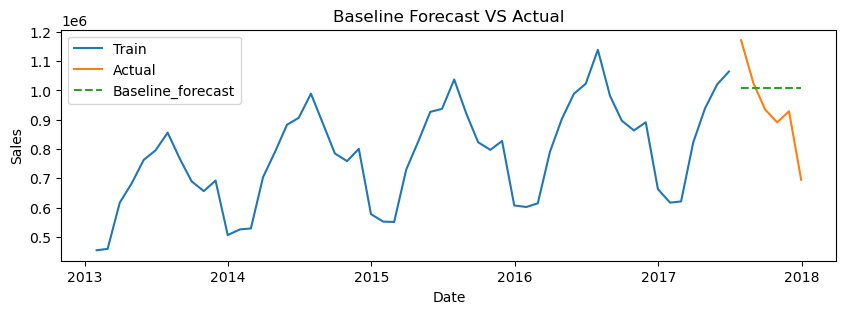

In [31]:
plt.figure(figsize = (10,3))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(baseline_prediction.index, baseline_prediction, label='Baseline_forecast', linestyle='--')
plt.legend()
plt.title('Baseline Forecast VS Actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

### Evaluate Mean Absolute error
#### Baseline performance

In [32]:
from sklearn.metrics import mean_absolute_error

In [33]:
baseline_mae = mean_absolute_error(test, baseline_prediction)
baseline_mae

127246.7777777778

**Baseline Result:**  
The baseline model provides a reference error level but does not capture seasonality or trend effectively.


## 8. ARIMA Model

ARIMA is a classical statistical model that captures temporal dependencies and trend through differencing.
It is evaluated to compare traditional forecasting methods against simpler baselines.


In [34]:
from statsmodels.tsa.arima.model import ARIMA

In [35]:
model = ARIMA(train, order=(1,1,1)) # (1,1,1) = (p,d,q)
arima_model = model.fit()

In [36]:
arima_forecast = arima_model.forecast(steps= len(test))
arima_forecast.index = test.index
# This predicts the nest 6 months 

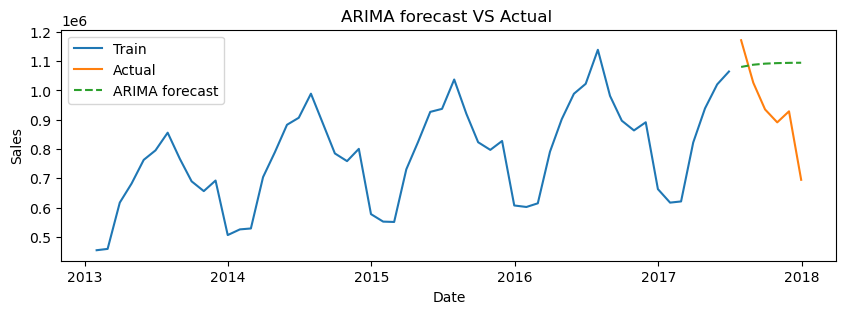

In [37]:
plt.figure(figsize= (10,3))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(arima_forecast.index, arima_forecast, label='ARIMA forecast', linestyle='--')
plt.legend()
plt.title('ARIMA forecast VS Actual ')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

### Evaluate ARIMA performance

In [38]:
from sklearn.metrics import mean_absolute_error
arima_mae = mean_absolute_error(test, arima_forecast)
arima_mae

179270.60266088066

**Observation:**  
The ARIMA model underperforms due to strong seasonality present in the data, which is not explicitly modeled.


In [39]:
baseline_mae

127246.7777777778

### Result:  BASELINE model performing better than ARIMA 

## 9. Prophet Model

Prophet is a time-series forecasting model designed for business applications.
It explicitly models trend and seasonality and is robust to noise and missing values.


In [40]:
prophet_df = monthly_series.reset_index()[['date','sales']]
prophet_df.columns = ['ds','y']

#### -“Prophet is opinionated by design. It enforces standardized column names (ds, y) to simplify model fitting and reduce ambiguity in time-series structure.”

In [41]:
prophet_df.head(3)

,ds,y
0,2013-01-31,328
1,2013-02-28,322
2,2013-03-31,477


In [42]:
train_prophet = prophet_df.iloc[:-6]
test_prophet = prophet_df.iloc[-6:]

In [43]:
from prophet import Prophet

In [44]:
# from prophet import Prophet


In [45]:
# import sys
# sys.executable

In [46]:
# C:\Users\abhis\AppData\Local\Microsoft\WindowsApps\python.exe

In [47]:
model = Prophet(
    yearly_seasonality = True,
    weekly_seasonality = False,
    daily_seasonality = False
)

In [48]:
model.fit(train_prophet)

15:02:45 - cmdstanpy - INFO - Chain [1] start processing
15:02:46 - cmdstanpy - INFO - Chain [1] done processing


In [49]:
future = model.make_future_dataframe(periods = 6, freq='ME')
forecast = model.predict(future)

In [50]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-31,479.928029,297.806977,365.238665,479.928029,479.928029,-148.308392,-148.308392,-148.308392,-148.308392,-148.308392,-148.308392,0.0,0.0,0.0,331.619638
1,2013-02-28,484.256962,278.029632,342.865894,484.256962,484.256962,-174.550752,-174.550752,-174.550752,-174.550752,-174.550752,-174.550752,0.0,0.0,0.0,309.706210
2,2013-03-31,489.049710,409.079836,474.608480,489.049710,489.049710,-48.421761,-48.421761,-48.421761,-48.421761,-48.421761,-48.421761,0.0,0.0,0.0,440.627949
3,2013-04-30,493.687852,489.017982,552.431148,493.687852,493.687852,28.940565,28.940565,28.940565,28.940565,28.940565,28.940565,0.0,0.0,0.0,522.628418
4,2013-05-31,498.480600,558.966095,626.017100,498.480600,498.480600,92.906090,92.906090,92.906090,92.906090,92.906090,92.906090,0.0,0.0,0.0,591.386690


In [51]:
prophet_forecast = forecast[['ds','yhat']].tail(6)
prophet_forecast.set_index('ds',inplace = True)

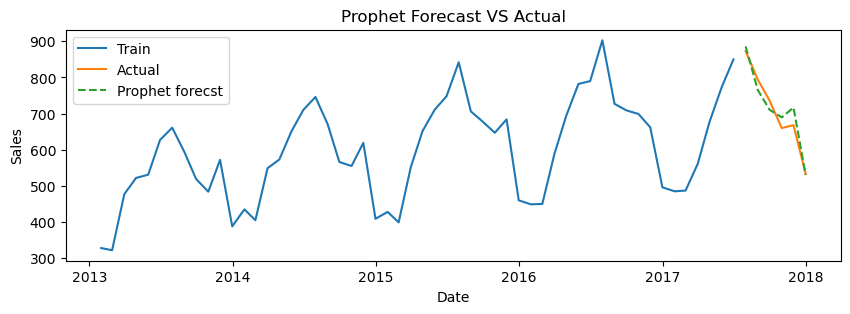

In [52]:
plt.figure(figsize=(10,3))
plt.plot(train_prophet['ds'], train_prophet['y'], label='Train')
plt.plot(test_prophet['ds'], test_prophet['y'], label='Actual')
plt.plot(prophet_forecast.index, prophet_forecast['yhat'], label='Prophet forecst', linestyle='--')
plt.legend()
plt.title('Prophet Forecast VS Actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [53]:
from sklearn.metrics import mean_absolute_error

In [54]:
prophet_mae = mean_absolute_error(
    test_prophet['y'],
    prophet_forecast['yhat']
)

prophet_mae

24.7194754706357

**Result:**  
Prophet achieves the lowest MAE, indicating superior performance in capturing demand patterns.


In [55]:
baseline_mae

127246.7777777778

In [56]:
test_prophet.head(3)

,ds,y
54,2017-07-31,873
55,2017-08-31,794
56,2017-09-30,736


In [57]:
prophet_forecast.head(3)

,yhat
ds,
2017-07-31,886.070282
2017-08-31,765.385424
2017-09-30,710.627505


### *************************************************************************************************************************
## 10. Model Comparison
| Model     | Performance |
|----------|-------------|
| Baseline | Weak        |
| ARIMA    | Poor        |
| Prophet  | Best        |

Prophet is selected as the final model due to its accuracy and interpretability.


### *********************************************************************************************************************

## 11. Business Insights and Conclusion

Key insights from this project:
- Demand exhibits strong seasonality and trend
- Simple baselines are insufficient for accurate forecasting
- Prophet effectively captures demand patterns and provides reliable forecasts

### Business Impact
The forecasting system can support:
- Inventory planning
- Demand-driven procurement
- Revenue forecasting

This project demonstrates an end-to-end time-series forecasting workflow suitable for real-world applications.


## 12. Final Output

### Technical Output
- A trained **Prophet time-series forecasting model** that predicts future demand based on historical sales data.
- Forecasted demand values for future dates at the **store–item level**.
- Quantitative evaluation using **Mean Absolute Error (MAE)** to compare models.

### Visual Output
- Time-series plots showing:
  - Historical sales (training data)
  - Actual sales (test data)
  - Forecasted sales using the Prophet model
- These visualizations help validate model performance and improve interpretability.

### Business Output
- Identification of strong **seasonality and trend** in retail demand.
- Selection of **Prophet as the final model** due to superior accuracy and robustness.
- Actionable insights that can be used for:
  - Inventory planning
  - Demand-driven procurement
  - Revenue forecasting

### Final Conclusion
The project successfully demonstrates an end-to-end demand forecasting workflow.  
By combining data preparation, exploratory analysis, model comparison, and business interpretation, the final solution provides reliable demand forecasts that can support real-world retail decision-making.
